<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Project <br>
<font color=696880 size=4>
    Project Team 

____


### Full Name : Mohammadreza Mofayezi
### Student Number : 98106059
___
### Full Name : Ali Hatami Tajik
### Student Number : 98101385
___

# Introduction

In this project, we are going to have a brief and elementary hands-on real-world project, predicting breast cancer survival using machine learning models with clinical data and gene expression profiles.

# Data Documentation

For this purpose, we will use "Breast Cancer Gene Expression Profiles (METABRIC)" data. 
The first 31 columns of data contain clinical information including death status.
The next columns of the data contain gene's related information which includes both gene expressions and mutation information. (gene's mutation info columns have been marked with "_mut" at the end of the names of the columns) 
For more information please read the [data documentation](https://www.kaggle.com/datasets/raghadalharbi/breast-cancer-gene-expression-profiles-metabric).

# Data Preparation (15 Points)

In this section you must first split data into three datasets:
<br>
1- clinical dataset
<br>
2- gene expressions dataset
<br>
3- gene mutation dataset. (We will not use this dataset in further steps of the project)

## Data Loading & Splitting

In [ ]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d raghadalharbi/breast-cancer-gene-expression-profiles-metabric
!unzip /content/breast-cancer-gene-expression-profiles-metabric.zip  -d /content

In [ ]:
!pip install upsetplot
!pip install umap-learn

In [4]:
# General
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from upsetplot import from_contents, UpSet

# Stats
from scipy import stats

# Split and prepare data for training
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import f1_score, confusion_matrix

# Classic Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.svm import SVC

# Deep Models
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

In [ ]:
dataset = pd.read_csv("/content/METABRIC_RNA_Mutation.csv")
clinical = dataset.loc[:, "patient_id":"death_from_cancer"]
gene_expr = dataset.loc[:, "brca1":"ugt2b7"]
gene_mut = dataset.loc[:, "pik3ca_mut":]
dataset = dataset.loc[:, :"ugt2b7"]

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (678,688,690,692) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
clinical.head()

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,6.044,IDC,140.500000,1,Negative,1,ER-/HER2-,22.0,2.0,Living
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,4.020,IDC,84.633333,1,Positive,1,ER+/HER2- High Prolif,10.0,1.0,Living
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,4.030,IDC,163.700000,0,Positive,0,NaN,15.0,2.0,Died of Disease
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,4.050,MDLC,164.933333,1,Positive,1,NaN,25.0,2.0,Living
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,6.080,MDLC,41.366667,0,Positive,1,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


In [ ]:
gene_expr.head()

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
0,-1.3990,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,-0.8361,-0.8578,...,-1.1877,-0.0194,-1.6345,-0.2142,-0.5698,-1.1741,-1.4779,-0.5954,-0.8847,-0.3354
1,-1.3800,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,0.5419,-2.6059,...,-0.4412,0.4534,0.4068,0.7634,0.0231,0.9121,-0.9538,-0.2264,0.5398,-0.8920
2,0.0670,-0.8426,0.2114,-0.3326,0.5141,-0.0803,1.1398,0.4187,-0.4030,-1.1305,...,-0.5381,0.0668,0.8344,1.7227,0.4024,-3.7172,-1.5538,1.3701,-0.1078,0.3655
3,0.6744,-0.5428,-1.6592,0.6369,1.6708,-0.8880,1.2491,-1.1889,-0.4174,-0.6165,...,-0.5630,-0.7078,0.8228,0.6819,-0.1948,-2.3286,-0.9924,-0.3154,0.2320,-0.4828
4,1.2932,-0.9039,-0.7219,0.2168,0.3484,0.3897,0.9131,0.9356,0.7675,-0.2940,...,-0.5845,-0.3544,-1.0150,2.2961,0.1817,-0.1572,0.0427,5.0048,3.8476,1.3223


In [ ]:
# change some lables
clinical["death_from_cancer"].replace({"Died of Disease":"Disease", 
                                       "Died of Other Causes": "Other"}, inplace=True)
print(clinical.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   patient_id                      1904 non-null   int64  
 1   age_at_diagnosis                1904 non-null   float64
 2   type_of_breast_surgery          1882 non-null   object 
 3   cancer_type                     1904 non-null   object 
 4   cancer_type_detailed            1889 non-null   object 
 5   cellularity                     1850 non-null   object 
 6   chemotherapy                    1904 non-null   int64  
 7   pam50_+_claudin-low_subtype     1904 non-null   object 
 8   cohort                          1904 non-null   float64
 9   er_status_measured_by_ihc       1874 non-null   object 
 10  er_status                       1904 non-null   object 
 11  neoplasm_histologic_grade       1832 non-null   float64
 12  her2_status_measured_by_snp6    19

We should change lable data to binary one so that they can be used as
data to be trained. Also null numbers/values should be replaced.

## EDA

For each dataset, you must perform a sufficient EDA.

### Overall

**Clinical:** In this section we will analyze the following effects on survival (Mostly Numerical Values):
  * Age
  * Tumor Stage
  * Tumor Size
  * Therapy Methods
  * Survival Time
  * Surgery Type

Then we will visualize the correlation betwean the parameters to see if the
dataset should be reduced or not.

**Gene Expression**: For gene expression profile since we donot have that much
of an expreience with genes, we leave the EDA part!

### Nullity
First we check how many null cells we have in the data (i.e. cells that has no
data in them and are not usable in the dataset). In the results we can see that
there is 25% missing data in the tumor stage which sounds like it should have a
huge impact on the death form factor, which we are going to predict.

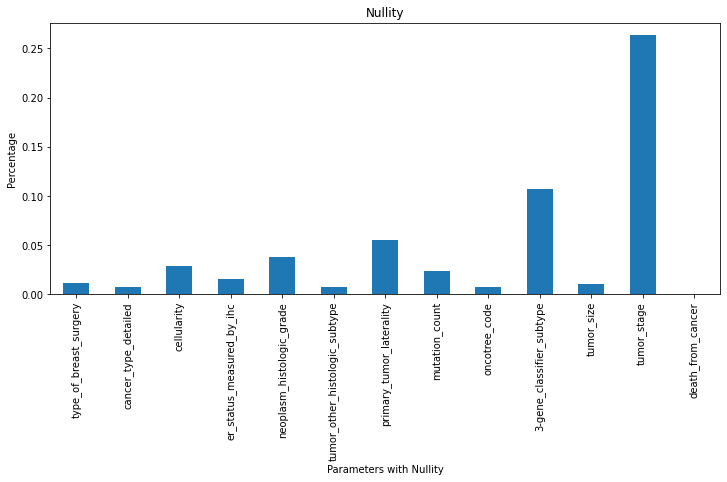

In [ ]:
nulls = clinical.isnull().mean()
nulls = nulls[nulls != 0]
nulls.plot.bar(figsize=(12,5))
plt.ylabel("Percentage")
plt.xlabel("Parameters with Nullity")
plt.title("Nullity")
plt.show()

### Survival


#### Age
From the charts below we can have the following interpretation that if the disease is diagnosed at early ages there is a better chance that the patient survive, but, we have to consider the fact that the death from the disease somehow overlaps with the living box and that chance isn't that much. At least we can say that diagnosis after age 85 is not effective.

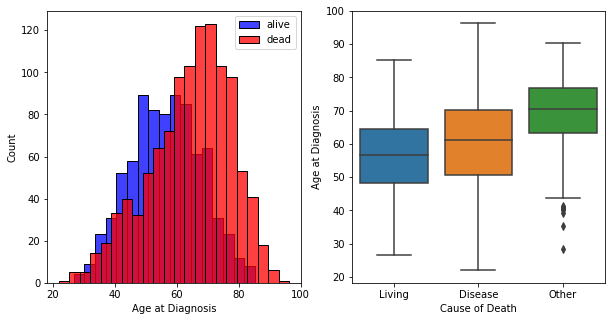

In [ ]:
# Survival vs Age
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# Distibution of dead and alive according to age
sns.histplot(clinical.loc[:,"age_at_diagnosis"][clinical["overall_survival"]==1], 
            color='b', ax=ax[0], label='alive')
sns.histplot(clinical.loc[:,"age_at_diagnosis"][clinical["overall_survival"]==0], 
            color='r', ax=ax[0], label='dead')
ax[0].set_xlabel("Age at Diagnosis")
ax[0].legend()

# Box plot of the death vause vs age
sns.boxplot(x='death_from_cancer', y='age_at_diagnosis', orient='v', 
            data=clinical, ax=ax[1])
ax[1].set_ylabel("Age at Diagnosis")
ax[1].set_xlabel("Cause of Death")

plt.show()

#### Tumor Stage
From the chart below, we can tell that if the patient is in stage 1 the probability of surviving is much higher if she was in stage 2, 3 or 4. Although in stage 2 the chance of surviving is pretty high.

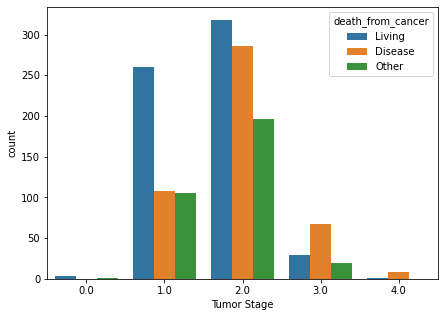

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
sns.countplot(x="tumor_stage", hue="death_from_cancer", ax=ax, data=clinical)
ax.set_xlabel("Tumor Stage")
plt.show()

#### Tumor Size
From the charts below we can say that the every tumor sizes kills! But when it's bigger, it will kill more. Also, tumors with bigger sizes are probable to be in stages 3 that considering the results in the section above, they will be more dangerous. 

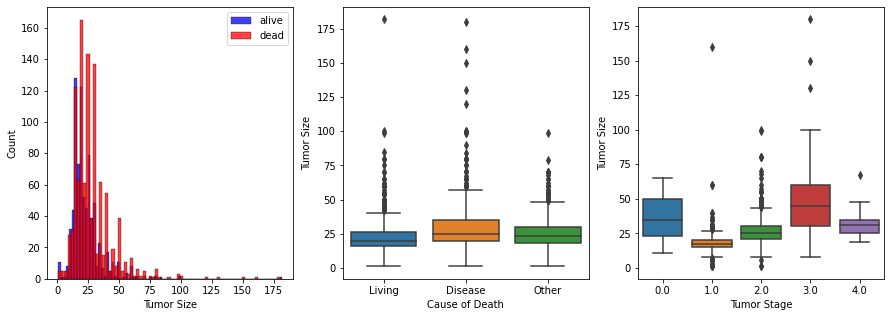

In [ ]:
# Survival vs Size
fig, ax = plt.subplots(1, 3, figsize=(15,5))

# Distibution of dead and alive according to size
sns.histplot(clinical.loc[:,"tumor_size"][clinical["overall_survival"]==1], 
            color='b', ax=ax[0], label='alive')
sns.histplot(clinical.loc[:,"tumor_size"][clinical["overall_survival"]==0], 
            color='r', ax=ax[0], label='dead')
ax[0].set_xlabel("Tumor Size")
ax[0].legend()

# Box plot of the death vause vs size
sns.boxplot(x='death_from_cancer', y='tumor_size', orient='v', 
            data=clinical, ax=ax[1])
ax[1].set_ylabel("Tumor Size")
ax[1].set_xlabel("Cause of Death")

sns.boxplot(x='tumor_stage', y='tumor_size', orient='v', 
            data=clinical, ax=ax[2])
ax[2].set_ylabel("Tumor Size")
ax[2].set_xlabel("Tumor Stage")

plt.show()

#### Therapy Methods
There are three therapy methods mentioned in the data set
  1. `chemotherapy`                   
  2. `radio_therapy`
  3. `hormone_therapy`

From the charts below we can find out:
  * Every patient tried at least one type of therapy
  * radio therapy and hormone therapies were more effective and 
      was used together more frequently.

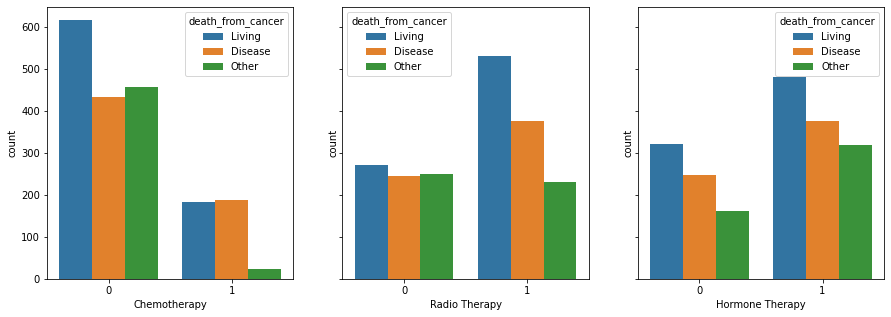

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharey=True)
sns.countplot(x="chemotherapy", hue="death_from_cancer", ax=ax[0], data=clinical)
ax[0].set_xlabel("Chemotherapy")

sns.countplot(x="radio_therapy", hue="death_from_cancer", ax=ax[1], data=clinical)
ax[1].set_xlabel("Radio Therapy")

sns.countplot(x="hormone_therapy", hue="death_from_cancer", ax=ax[2], data=clinical)
ax[2].set_xlabel("Hormone Therapy")

plt.show()

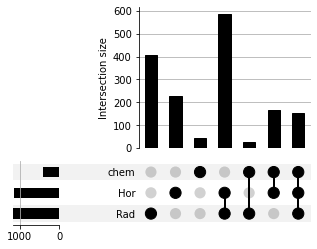

In [ ]:
C = clinical["chemotherapy"].astype(bool)
H = clinical["radio_therapy"].astype(bool)
R = clinical["hormone_therapy"].astype(bool)

C_i = C[C].index
H_i = H[H].index
R_i = R[R].index

therapies = from_contents({'chem': C_i, 'Hor':H_i, 'Rad':R_i})
UpSet(therapies, subset_size='count').plot()
plt.show()

#### Survival Time
From the charts below we can findout that as you survive the disease, it is more probable that you be cured in the future.

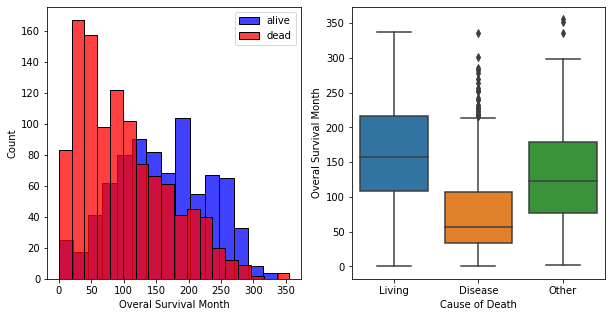

In [ ]:
# Survival vs Time
fig, ax = plt.subplots(1, 2, figsize=(10,5))

# Distibution of dead and alive according to Time
sns.histplot(clinical.loc[:,"overall_survival_months"][clinical["overall_survival"]==1], 
            color='b', ax=ax[0], label='alive')
sns.histplot(clinical.loc[:,"overall_survival_months"][clinical["overall_survival"]==0], 
            color='r', ax=ax[0], label='dead')
ax[0].set_xlabel("Overal Survival Month")
ax[0].legend()

# Box plot of the death vause vs Time
sns.boxplot(x='death_from_cancer', y='overall_survival_months', orient='v', 
            data=clinical, ax=ax[1])
ax[1].set_ylabel("Overal Survival Month")
ax[1].set_xlabel("Cause of Death")

plt.show()

#### Breast Surgery Type
Although conserving breast surgeries are more probable to cure, they are not performed on big tumors.

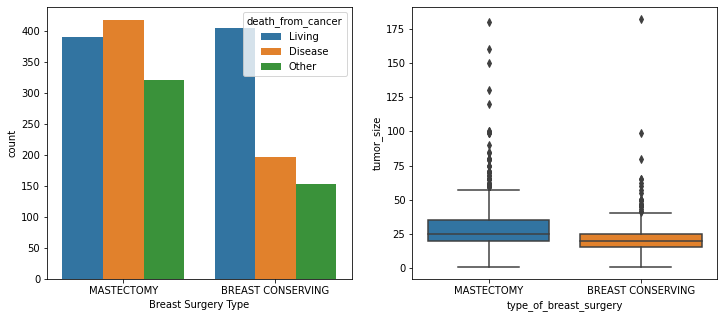

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,5))

sns.countplot(x="type_of_breast_surgery", hue="death_from_cancer", ax=ax1, data=clinical)
ax1.set_xlabel("Breast Surgery Type")

# Breast Surgery vs Tumor Size
sns.boxplot(x='type_of_breast_surgery', y='tumor_size', data=clinical, 
            orient='v', ax=ax2)

plt.show()

### Correlations

From the chart below we can see that the effect of multiple features on overal survival is almost nothing.

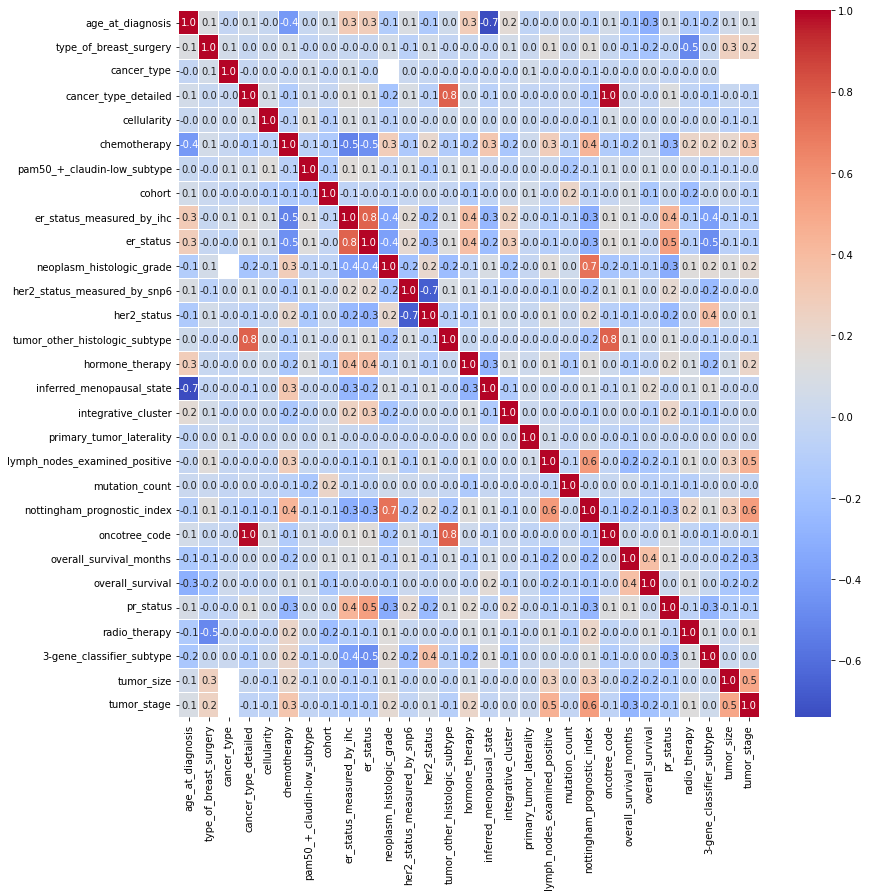

In [ ]:
f, ax = plt.subplots(figsize=(13, 13))
df = clinical.drop(['death_from_cancer', 'patient_id'], axis=1)

object_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in object_cols:
  df[col] = LabelEncoder().fit_transform(df[col].values)
corr = df.corr()
sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm", fmt='.1f',
                 linewidths=.05)
plt.show()

In [ ]:
surv_corr_sorted = corr["overall_survival"].sort_values(ascending = False)

print("Positive Correlations on Survival:")
print(surv_corr_sorted.head(10))
print("---------------------------------------------------")
print("Negative Correlations on Survival:")
print(surv_corr_sorted.tail(10))

Positive Correlations on Survival:
overall_survival                  1.000000
overall_survival_months           0.384467
inferred_menopausal_state         0.170915
radio_therapy                     0.112083
pam50_+_claudin-low_subtype       0.063790
chemotherapy                      0.045625
tumor_other_histologic_subtype    0.033787
cancer_type                       0.026900
her2_status_measured_by_snp6      0.024611
pr_status                         0.022425
Name: overall_survival, dtype: float64
---------------------------------------------------
Negative Correlations on Survival:
mutation_count                  -0.077741
integrative_cluster             -0.082834
neoplasm_histologic_grade       -0.086601
nottingham_prognostic_index     -0.138000
cohort                          -0.149645
tumor_size                      -0.164361
lymph_nodes_examined_positive   -0.164498
type_of_breast_surgery          -0.182882
tumor_stage                     -0.188790
age_at_diagnosis               

### Gene Expression

In [ ]:
gene_expr.describe()

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
count,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,1.904000e+03,1904.000000,...,1.904000e+03,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03,1.904000e+03,1.904000e+03,1904.000000,1.904000e+03
mean,-6.302521e-07,-4.201681e-07,3.676471e-07,-8.928571e-07,6.302521e-07,-2.100840e-07,0.000002,7.463684e-18,-3.676471e-07,-0.000001,...,4.726891e-07,-3.676471e-07,-9.453782e-07,-1.050420e-07,-0.000002,3.676471e-07,4.726891e-07,7.878151e-07,0.000000,3.731842e-18
std,1.000262e+00,1.000262e+00,1.000263e+00,1.000263e+00,1.000263e+00,1.000262e+00,1.000263,1.000262e+00,1.000263e+00,1.000262,...,1.000263e+00,1.000262e+00,1.000262e+00,1.000263e+00,1.000262,1.000264e+00,1.000262e+00,1.000263e+00,1.000262,1.000262e+00
min,-2.444400e+00,-2.783500e+00,-4.384600e+00,-5.932800e+00,-2.481200e+00,-3.170500e+00,-3.323700,-2.688700e+00,-3.689800e+00,-2.968600,...,-2.120800e+00,-3.364800e+00,-2.719400e+00,-4.982700e+00,-2.981700,-3.833300e+00,-3.609300e+00,-1.166900e+00,-2.112600,-1.051600e+00
25%,-7.198500e-01,-6.994750e-01,-6.798250e-01,-5.586500e-01,-6.661500e-01,-6.602250e-01,-0.458600,-7.385500e-01,-6.667750e-01,-0.683925,...,-6.188500e-01,-6.104750e-01,-6.741750e-01,-6.136750e-01,-0.632900,-6.664750e-01,-7.102000e-01,-5.058250e-01,-0.476200,-7.260000e-01
50%,-1.244500e-01,-5.820000e-02,-2.210000e-02,1.098500e-01,-3.010000e-02,-4.200000e-03,0.115550,-1.311000e-01,-1.445000e-02,-0.054800,...,-2.456500e-01,-4.690000e-02,-1.422500e-01,-5.175000e-02,-0.026650,7.000000e-04,-2.980000e-02,-2.885500e-01,-0.133400,-4.248000e-01
75%,5.532250e-01,6.290000e-01,6.400000e-01,6.426250e-01,6.447500e-01,6.901500e-01,0.649800,5.431250e-01,6.387250e-01,0.668925,...,3.306000e-01,5.144500e-01,5.146000e-01,5.787750e-01,0.590350,6.429000e-01,5.957250e-01,6.022500e-02,0.270375,4.284000e-01
max,4.554200e+00,3.737900e+00,4.615000e+00,3.254100e+00,4.289800e+00,3.824200e+00,2.820900,4.538200e+00,5.371300e+00,6.178600,...,6.534900e+00,1.027030e+01,6.329000e+00,4.571300e+00,12.742300,3.938800e+00,3.833400e+00,1.088490e+01,12.643900,3.284400e+00


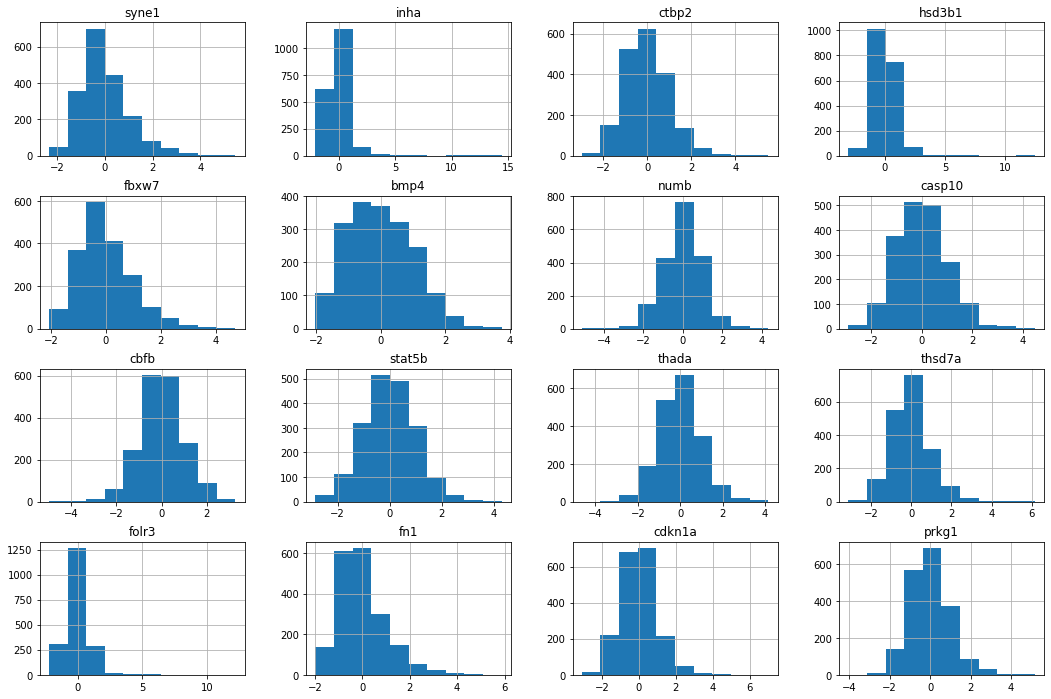

In [ ]:
gene_expr.sample(n=16,axis='columns').hist(figsize=(18,12))
plt.show()

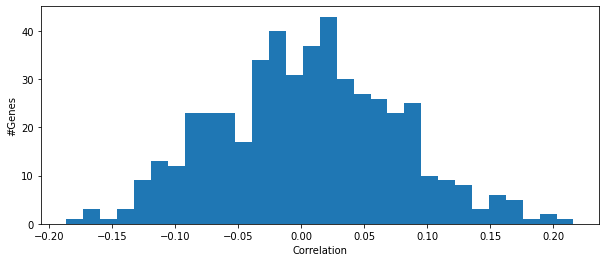

In [ ]:
#how varied are genes and how well do they correlate with eventdeath?
fig, ax = plt.subplots(figsize=(10,4))

#plot histogram of variation using standard deviation as a measure
corrs=[]
for col in gene_expr.columns:
    corr = gene_expr[col].corr(clinical['overall_survival'])
    corrs.append(corr)

ax.hist(corrs, bins=30)
ax.set_xlabel("Correlation")
ax.set_ylabel("#Genes")
plt.show()

# Train Test Split

In the following cells, we split the data into train, validation and test sets. `death_from_cancer` is removed from clinical dataset because it will determine output exactly and there will nothing remain to learn! object data (Which is string data) is encoded using scikitlearn `LabelEncoder`.

In [ ]:
X = dataset.dropna()
y = X[['overall_survival']].to_numpy()
y = y.reshape(y.shape[0])
X = X.drop(['death_from_cancer', 'overall_survival', 'patient_id'], axis=1)

object_cols = X.select_dtypes(include=['object']).columns.tolist()
for col in object_cols:
  X[col] = LabelEncoder().fit_transform(X[col].values)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
X_clinical_train = X_train.loc[:, :'tumor_stage'].to_numpy()
X_gene_train = X_train.loc[:, "brca1":].to_numpy()
X_clinical_val = X_val.loc[:, :'tumor_stage'].to_numpy()
X_gene_val = X_val.loc[:, "brca1":].to_numpy()
X_clinical_test = X_test.loc[:, :'tumor_stage'].to_numpy()
X_gene_test = X_test.loc[:, "brca1":].to_numpy()

In [ ]:
# Normalize Data of clinical data
clinical_scaler = StandardScaler()
clinical_scaler.fit(X_clinical_train)
X_clinical_train_norm = clinical_scaler.transform(X_clinical_train)
X_clinical_val_norm = clinical_scaler.transform(X_clinical_val)
X_clinical_test_norm = clinical_scaler.transform(X_clinical_test)

# Dimension Reduction (20 + Up to 10 Points Optional)

For each dataset, investigate whether it is needed to use a dimensionality reduction approach or not. If yes, please reduce the dataset's dimension. You can use UMAP for this purpose but any other approach is acceptable. Finding the most important features contains extra points.

**NOTE:** We used only the training data to reduce the dimention of the test and validation sets so that the results matches realworld practice and to be unbiased.



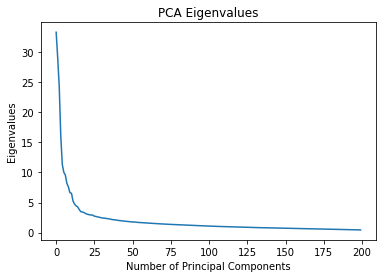

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(200).fit(X_gene_train)

fig = plt.figure()
plt.xlabel('Number of Principal Components')
plt.ylabel('Eigenvalues')
plt.title('PCA Eigenvalues')
plt.style.context('seaborn-whitegrid')
plt.plot(pca.explained_variance_)
plt.show()

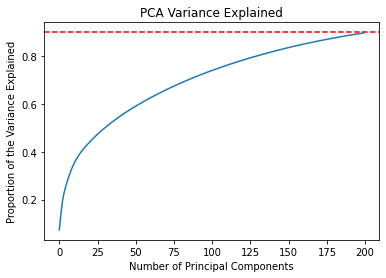

In [ ]:
variance = np.cumsum(pca.explained_variance_ratio_)

fig = plt.figure()
plt.xlabel('Number of Principal Components')
plt.ylabel('Proportion of the Variance Explained')
plt.title('PCA Variance Explained')
plt.style.context('seaborn-whitegrid')
plt.axhline(y=0.9, color='r', linestyle='--')
plt.plot(variance)
plt.show()

In [ ]:
from umap import UMAP

umap_enc = UMAP(n_components=10, random_state=42)
umap_enc.fit(X_gene_train)
X_gene_reduced_train = umap_enc.transform(X_gene_train)
X_gene_reduced_val = umap_enc.transform(X_gene_val)
X_gene_reduced_test = umap_enc.transform(X_gene_test)

# Classic Model (25 Points)

In this section, you must implement a classic classification model for clinical, gene expressions, and reduced gene expressions datasets. Using Random Forest is suggested. (minimum acceptable accuracy = 60%)

## Foreword

As it was mentioned in the Quera that we can use any module and library that we want, we will use scikit learn library to build and train our model. We didn't stopped at Random Forest model and examined different methods for the datasets and compared them together. This work is done for each dataset (i.e. clinical, gene expression and reduced gene expression). The models that are used are as follow:
* Random Forest
* Logistic Regression
* AdaBoost
* XGBoost
* Support Vector Classifier

## Clinical

In this section we use clinical data to classify the `overall_survival` feature.

In [ ]:
# Random Forest
rf_clf = RandomForestClassifier(random_state=42, max_depth=50)
rf_clf.fit(X_clinical_train, y_train)

# Logestic Regression
lr_clf = LogisticRegression(random_state=42, penalty='l2')
lr_clf.fit(X_clinical_train_norm, y_train)

# AdaBoost
ada_clf = AdaBoostClassifier(n_estimators=100)
ada_clf.fit(X_clinical_train, y_train)

# XGBoost
xgb_clf = XGBClassifier()
xgb_clf.fit(X_clinical_train, y_train)

# SVC
svc_clf = SVC(gamma='auto')
svc_clf.fit(X_clinical_train_norm, y_train)

SVC(gamma='auto')

In [ ]:
# Generate Predictions
predictions = {
  "Train": {
    "Random Forest": rf_clf.predict(X_clinical_train),
    "Logistic Regression": lr_clf.predict(X_clinical_train_norm),
    "Ada Boost": ada_clf.predict(X_clinical_train),
    "XGBoost": xgb_clf.predict(X_clinical_train),
    "SVC": svc_clf.predict(X_clinical_train_norm),
  },
  "Test":{
    "Random Forest": rf_clf.predict(X_clinical_test),
    "Logistic Regression": lr_clf.predict(X_clinical_test_norm),
    "Ada Boost": ada_clf.predict(X_clinical_test),
    "XGBoost": xgb_clf.predict(X_clinical_test),
    "SVC": svc_clf.predict(X_clinical_test_norm)
  }
}

In [ ]:
# Calculate Accuracy Scores
accuracy = {}
y_true = {"Train": y_train, "Test": y_test}

for stage, models in predictions.items():
  accuracy[stage] = {}
  for model, y_pred in models.items():
    accuracy[stage][model] = accuracy_score(y_true[stage], y_pred)

In [ ]:
# Print and Visualize Accuracies
for stage, models in accuracy.items():
  print("="*10, stage, "="*(30 - len(stage)))
  for model, acc in models.items():
    print(" " * 5, model, ": ", "%.2f"%(acc))

========== Train =========================
      Random Forest :  1.00
      Logistic Regression :  0.79
      Ada Boost :  0.87
      XGBoost :  0.90
      SVC :  0.87
========== Test ==========================
      Random Forest :  0.76
      Logistic Regression :  0.71
      Ada Boost :  0.75
      XGBoost :  0.75
      SVC :  0.76


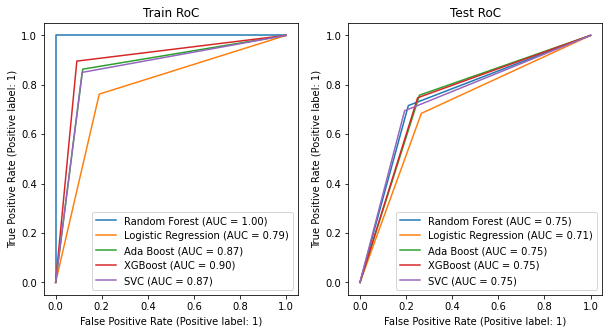

In [ ]:
# Visualize RoC Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax = {"Train": ax1, "Test": ax2}
y_true = {"Train": y_train, "Test": y_test}

for stage, models in predictions.items():
  ax[stage].set_title(stage + " RoC")
  for model, y_pred in models.items():
    RocCurveDisplay.from_predictions(y_true[stage], y_pred, name=model, 
                                       ax=ax[stage])
    
plt.show()

## Gene Expression

In [ ]:
# Random Forest
rf_clf = RandomForestClassifier(random_state=42, max_depth=5)
rf_clf.fit(X_gene_train, y_train)

# Logestic Regression
lr_clf = LogisticRegression(random_state=42, penalty='l2')
lr_clf.fit(X_gene_train, y_train)

# AdaBoost
ada_clf = AdaBoostClassifier(n_estimators=100)
ada_clf.fit(X_gene_train, y_train)

# XGBoost
xgb_clf = XGBClassifier()
xgb_clf.fit(X_gene_train, y_train)

# SVC
svc_clf = SVC(gamma='auto')
svc_clf.fit(X_gene_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVC(gamma='auto')

In [ ]:
# Generate Predictions
predictions = {
  "Train": {
    "Random Forest": rf_clf.predict(X_gene_train),
    "Logistic Regression": lr_clf.predict(X_gene_train),
    "Ada Boost": ada_clf.predict(X_gene_train),
    "XGBoost": xgb_clf.predict(X_gene_train),
    "SVC": svc_clf.predict(X_gene_train),
  },
  "Test":{
    "Random Forest": rf_clf.predict(X_gene_test),
    "Logistic Regression": lr_clf.predict(X_gene_test),
    "Ada Boost": ada_clf.predict(X_gene_test),
    "XGBoost": xgb_clf.predict(X_gene_test),
    "SVC": svc_clf.predict(X_gene_test)
  }
}

In [ ]:
# Calculate Accuracy Scores
accuracy = {}
y_true = {"Train": y_train, "Test": y_test}

for stage, models in predictions.items():
  accuracy[stage] = {}
  for model, y_pred in models.items():
    accuracy[stage][model] = accuracy_score(y_true[stage], y_pred)

In [ ]:
# Print and Visualize Accuracies
for stage, models in accuracy.items():
  print("="*10, stage, "="*(30 - len(stage)))
  for model, acc in models.items():
    print(" " * 5, model, ": ", "%.2f"%(acc))

========== Train =========================
      Random Forest :  0.95
      Logistic Regression :  1.00
      Ada Boost :  0.98
      XGBoost :  1.00
      SVC :  0.93
========== Test ==========================
      Random Forest :  0.64
      Logistic Regression :  0.63
      Ada Boost :  0.58
      XGBoost :  0.66
      SVC :  0.70


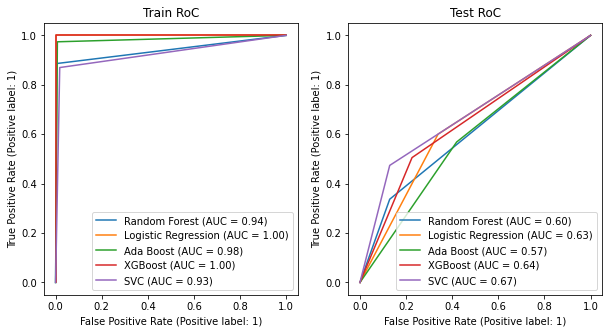

In [ ]:
# Visualize RoC Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax = {"Train": ax1, "Test": ax2}
y_true = {"Train": y_train, "Test": y_test}

for stage, models in predictions.items():
  ax[stage].set_title(stage + " RoC")
  for model, y_pred in models.items():
    RocCurveDisplay.from_predictions(y_true[stage], y_pred, name=model, 
                                       ax=ax[stage])
    
plt.show()

## Reduced Gene Expression

In [ ]:
# Random Forest
rf_clf = RandomForestClassifier(random_state=42, max_depth=5)
rf_clf.fit(X_gene_reduced_train, y_train)

# Logestic Regression
lr_clf = LogisticRegression(random_state=42, penalty='l2')
lr_clf.fit(X_gene_reduced_train, y_train)

# AdaBoost
ada_clf = AdaBoostClassifier(n_estimators=100)
ada_clf.fit(X_gene_reduced_train, y_train)

# XGBoost
xgb_clf = XGBClassifier()
xgb_clf.fit(X_gene_reduced_train, y_train)

# SVC
svc_clf = SVC(gamma='auto')
svc_clf.fit(X_gene_reduced_train, y_train)

SVC(gamma='auto')

In [ ]:
# Generate Predictions
predictions = {
  "Train": {
    "Random Forest": rf_clf.predict(X_gene_reduced_train),
    "Logistic Regression": lr_clf.predict(X_gene_reduced_train),
    "Ada Boost": ada_clf.predict(X_gene_reduced_train),
    "XGBoost": xgb_clf.predict(X_gene_reduced_train),
    "SVC": svc_clf.predict(X_gene_reduced_train),
  },
  "Test":{
    "Random Forest": rf_clf.predict(X_gene_reduced_test),
    "Logistic Regression": lr_clf.predict(X_gene_reduced_test),
    "Ada Boost": ada_clf.predict(X_gene_reduced_test),
    "XGBoost": xgb_clf.predict(X_gene_reduced_test),
    "SVC": svc_clf.predict(X_gene_reduced_test)
  }
}

In [ ]:
# Calculate Accuracy Scores
accuracy = {}
y_true = {"Train": y_train, "Test": y_test}

for stage, models in predictions.items():
  accuracy[stage] = {}
  for model, y_pred in models.items():
    accuracy[stage][model] = accuracy_score(y_true[stage], y_pred)

In [ ]:
# Print and Visualize Accuracies
for stage, models in accuracy.items():
  print("="*10, stage, "="*(30 - len(stage)))
  for model, acc in models.items():
    print(" " * 5, model, ": ", "%.2f"%(acc))

========== Train =========================
      Random Forest :  0.80
      Logistic Regression :  0.60
      Ada Boost :  0.80
      XGBoost :  0.85
      SVC :  0.60
========== Test ==========================
      Random Forest :  0.65
      Logistic Regression :  0.64
      Ada Boost :  0.60
      XGBoost :  0.62
      SVC :  0.66


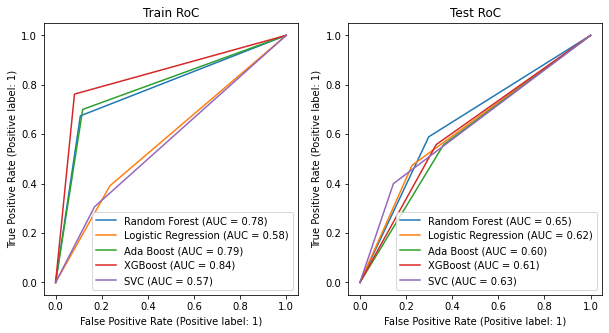

In [ ]:
# Visualize RoC Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax = {"Train": ax1, "Test": ax2}
y_true = {"Train": y_train, "Test": y_test}

for stage, models in predictions.items():
  ax[stage].set_title(stage + " RoC")
  for model, y_pred in models.items():
    RocCurveDisplay.from_predictions(y_true[stage], y_pred, name=model, 
                                       ax=ax[stage])
    
plt.show()

# Neural Network (30 Points)

In this section, you must implement a neural network model for clinical, gene expressions and reduced gene expressions datasets. Using the MPL models is suggested. (minimum acceptable accuracy = 60%)

## Setup

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
torch.manual_seed(42)

In [ ]:
class TabularDataset(Dataset):
  def __init__(self, X, y, ytype=torch.long):
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=ytype)
 
  def __len__(self):
    return len(self.y)
   
  def __getitem__(self,idx):
    return self.X[idx], self.y[idx]

In [ ]:
clinical_features = X_clinical_train.shape[1]
gene_exp_features = X_gene_train.shape[1]
gene_exp_reduced_features = X_gene_reduced_train.shape[1]

## Models

In [ ]:
class ClinicalClassifier(nn.Module):
    def __init__(self):
        super(ClinicalClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(clinical_features, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 2),
        )

    def forward(self, x):
        return self.model(x)

class GeneExpressionClassifier(nn.Module):
    def __init__(self):
        super(GeneExpressionClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(gene_exp_features, 16),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(16, 2)
        )

    def forward(self, x):
        return self.model(x)

class ReducedGeneExpressionClassifier(nn.Module):
    def __init__(self):
        super(ReducedGeneExpressionClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(gene_exp_reduced_features, 7),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(7, 2)
        )

    def forward(self, x):
        return self.model(x)

## Clinical Dataset

In [ ]:
clinical_model = ClinicalClassifier().to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(clinical_model.parameters(), lr=learning_rate)

### Dataloaders

In [ ]:
batch_size = 64

train_dataset = TabularDataset(X_clinical_train, y_train)
val_dataset = TabularDataset(X_clinical_val, y_val)
test_dataset = TabularDataset(X_clinical_test, y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Training the Model

In [ ]:
num_epochs = 10

train_losses, val_losses = [], []
best_loss = np.inf

for epoch in range(num_epochs):
    train_loss, val_loss = 0, 0
    clinical_model.train()
    with tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for i, (X, y) in pbar:  
            X = X.to(device=device)
            y = y.to(device=device)
            optimizer.zero_grad()
            scores = clinical_model(X)
            batch_loss = criterion(scores, y)
            train_loss += batch_loss * batch_size
            batch_loss.backward()
            optimizer.step()
            pbar.set_description(f'Train {epoch} | Loss:{train_loss/((i + 1) * batch_size):.4f}')

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss.detach().cpu().numpy())

    with torch.no_grad():
        with tqdm(enumerate(val_loader), total=len(val_loader)) as pbar:
            for i, (X, y) in pbar:
                X = X.to(device=device)
                y = y.to(device=device)
                scores = clinical_model(X)
                batch_loss = criterion(scores, y)
                val_loss += batch_loss * batch_size
                pbar.set_description(f'Val {epoch} | Loss:{val_loss/((i + 1) * batch_size):.4f}')

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss.detach().cpu().numpy())

    if val_loss < best_loss:
        torch.save(clinical_model.state_dict(), 'best_clinical.pth')
        best_loss = val_loss

Train 0 | Loss:0.6769: 100%|██████████| 11/11 [00:00<00:00, 135.10it/s]
Val 0 | Loss:0.6600: 100%|██████████| 3/3 [00:00<00:00, 277.58it/s]
Train 1 | Loss:0.6365: 100%|██████████| 11/11 [00:00<00:00, 148.18it/s]
Val 1 | Loss:0.6336: 100%|██████████| 3/3 [00:00<00:00, 254.86it/s]
Train 2 | Loss:0.6055: 100%|██████████| 11/11 [00:00<00:00, 102.07it/s]
Val 2 | Loss:0.6159: 100%|██████████| 3/3 [00:00<00:00, 234.76it/s]
Train 3 | Loss:0.5856: 100%|██████████| 11/11 [00:00<00:00, 113.43it/s]
Val 3 | Loss:0.6100: 100%|██████████| 3/3 [00:00<00:00, 232.35it/s]
Train 4 | Loss:0.5736: 100%|██████████| 11/11 [00:00<00:00, 93.94it/s]
Val 4 | Loss:0.6095: 100%|██████████| 3/3 [00:00<00:00, 168.69it/s]
Train 5 | Loss:0.5630: 100%|██████████| 11/11 [00:00<00:00, 116.46it/s]
Val 5 | Loss:0.5863: 100%|██████████| 3/3 [00:00<00:00, 193.27it/s]
Train 6 | Loss:0.5475: 100%|██████████| 11/11 [00:00<00:00, 127.59it/s]
Val 6 | Loss:0.5853: 100%|██████████| 3/3 [00:00<00:00, 228.15it/s]
Train 7 | Loss:0.5397

### Plot Losses

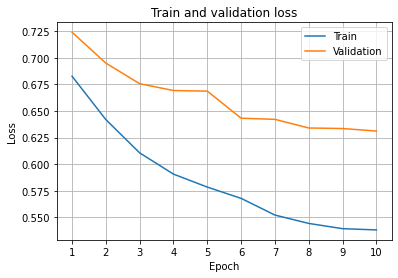

In [ ]:
fig, ax = plt.subplots()
epochs = [str(i + 1) for i in range(num_epochs)]
ax.plot(epochs, train_losses, label='Train')
ax.plot(epochs, val_losses, label='Validation')
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Train and validation loss')
ax.legend()
plt.show()

### Test the Model

Test Loss:0.5270: 100%|██████████| 4/4 [00:00<00:00, 98.60it/s]



158 / 219 correct (Acc.: 72.1461 and loss: 0.6161)


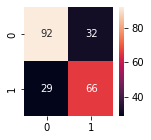

In [ ]:
confusion = np.zeros(shape=(2, 2))
num_samples = 0
num_correct = 0
loss = 0

clinical_model.eval()
with torch.no_grad():
     with tqdm(enumerate(test_loader), total=len(test_loader)) as pbar:
       for i, (X, y) in pbar:
            X = X.to(device=device)
            y = y.to(device=device)
            scores = clinical_model(X)
            batch_loss = criterion(scores, y)
            loss += batch_loss * batch_size
            _, preds = scores.max(1)
            confusion += confusion_matrix(y.detach().cpu().numpy(), preds.detach().cpu().numpy(), labels=np.arange(2))
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            pbar.set_description(f'Test Loss:{loss/((i + 1) * batch_size):.4f}')
loss /= len(test_loader.dataset)

acc = float(num_correct) / num_samples
print(f'\n{num_correct} / {num_samples} correct (Acc.: {100 * acc:.4f} and loss: {loss:.4f})')

plt.figure(figsize = (2,2))
sns.heatmap(confusion, annot=True)
plt.show()

## Gene Expression Dataset

In [ ]:
torch.manual_seed(5)

gene_exp_model = GeneExpressionClassifier().to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(gene_exp_model.parameters(), lr=learning_rate)

### Dataloaders

In [ ]:
batch_size = 64

train_dataset = TabularDataset(X_gene_train, y_train)
val_dataset = TabularDataset(X_gene_val, y_val)
test_dataset = TabularDataset(X_gene_test, y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Training the Model

In [ ]:
num_epochs = 10

train_losses, val_losses = [], []
best_loss = np.inf

for epoch in range(num_epochs):
    train_loss, val_loss = 0, 0
    gene_exp_model.train()
    with tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for i, (X, y) in pbar:  
            X = X.to(device=device)
            y = y.to(device=device)
            optimizer.zero_grad()
            scores = gene_exp_model(X)
            batch_loss = criterion(scores, y)
            train_loss += batch_loss * batch_size
            batch_loss.backward()
            optimizer.step()
            pbar.set_description(f'Train {epoch} | Loss:{train_loss/((i + 1) * batch_size):.4f}')

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss.detach().cpu().numpy())

    with torch.no_grad():
        with tqdm(enumerate(val_loader), total=len(val_loader)) as pbar:
            for i, (X, y) in pbar:
                X = X.to(device=device)
                y = y.to(device=device)
                scores = gene_exp_model(X)
                batch_loss = criterion(scores, y)
                val_loss += batch_loss * batch_size
                pbar.set_description(f'Val {epoch} | Loss:{val_loss/((i + 1) * batch_size):.4f}')

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss.detach().cpu().numpy())

    if val_loss < best_loss:
        torch.save(gene_exp_model.state_dict(), 'best_gene.pth')
        best_loss = val_loss

Train 0 | Loss:0.7030: 100%|██████████| 11/11 [00:00<00:00, 136.53it/s]
Val 0 | Loss:0.6384: 100%|██████████| 3/3 [00:00<00:00, 194.14it/s]
Train 1 | Loss:0.6459: 100%|██████████| 11/11 [00:00<00:00, 97.71it/s] 
Val 1 | Loss:0.6398: 100%|██████████| 3/3 [00:00<00:00, 160.11it/s]
Train 2 | Loss:0.6268: 100%|██████████| 11/11 [00:00<00:00, 97.68it/s]
Val 2 | Loss:0.6443: 100%|██████████| 3/3 [00:00<00:00, 221.42it/s]
Train 3 | Loss:0.6021: 100%|██████████| 11/11 [00:00<00:00, 122.00it/s]
Val 3 | Loss:0.6369: 100%|██████████| 3/3 [00:00<00:00, 106.86it/s]
Train 4 | Loss:0.5834: 100%|██████████| 11/11 [00:00<00:00, 109.49it/s]
Val 4 | Loss:0.6120: 100%|██████████| 3/3 [00:00<00:00, 204.04it/s]
Train 5 | Loss:0.5554: 100%|██████████| 11/11 [00:00<00:00, 97.66it/s] 
Val 5 | Loss:0.6250: 100%|██████████| 3/3 [00:00<00:00, 197.93it/s]
Train 6 | Loss:0.5427: 100%|██████████| 11/11 [00:00<00:00, 124.08it/s]
Val 6 | Loss:0.6512: 100%|██████████| 3/3 [00:00<00:00, 250.78it/s]
Train 7 | Loss:0.5277

### Plot Losses

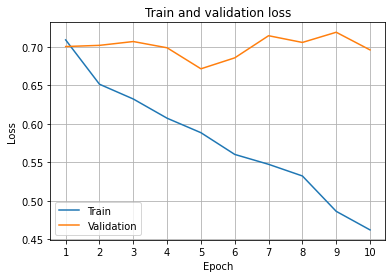

In [ ]:
fig, ax = plt.subplots()
epochs = [str(i + 1) for i in range(num_epochs)]
ax.plot(epochs, train_losses, label='Train')
ax.plot(epochs, val_losses, label='Validation')
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Train and validation loss')
ax.legend()
plt.show()

### Test the Model

Test Loss:0.6108: 100%|██████████| 4/4 [00:00<00:00, 132.25it/s]



152 / 219 correct (Acc.: 69.40639269406392 and loss: 0.7140)


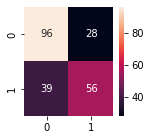

In [ ]:
confusion = np.zeros(shape=(2, 2))
num_samples = 0
num_correct = 0
loss = 0

gene_exp_model.eval()
with torch.no_grad():
     with tqdm(enumerate(test_loader), total=len(test_loader)) as pbar:
       for i, (X, y) in pbar:
            X = X.to(device=device)
            y = y.to(device=device)
            scores = gene_exp_model(X)
            batch_loss = criterion(scores, y)
            loss += batch_loss * batch_size
            _, preds = scores.max(1)
            confusion += confusion_matrix(y.detach().cpu().numpy(), preds.detach().cpu().numpy(), labels=np.arange(2))
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            pbar.set_description(f'Test Loss:{loss/((i + 1) * batch_size):.4f}')
loss /= len(test_loader.dataset)

acc = float(num_correct) / num_samples
print(f'\n{num_correct} / {num_samples} correct (Acc.: {100 * acc} and loss: {loss:.4f})')

plt.figure(figsize = (2,2))
sns.heatmap(confusion, annot=True)
plt.show()

## Reduced Gene Expression Dataset

In [ ]:
reduced_gene_exp_model = ReducedGeneExpressionClassifier().to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(reduced_gene_exp_model.parameters(), lr=learning_rate)

### Dataloaders

In [ ]:
batch_size = 64

train_dataset = TabularDataset(X_gene_reduced_train, y_train)
val_dataset = TabularDataset(X_gene_reduced_val, y_val)
test_dataset = TabularDataset(X_gene_reduced_test, y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### Training the Model

In [ ]:
num_epochs = 15
train_losses, val_losses = [], []
best_loss = np.inf

for epoch in range(num_epochs):
    train_loss, val_loss = 0, 0
    reduced_gene_exp_model.train()
    with tqdm(enumerate(train_loader), total=len(train_loader)) as pbar:
        for i, (X, y) in pbar:  
            X = X.to(device=device)
            y = y.to(device=device)
            optimizer.zero_grad()
            scores = reduced_gene_exp_model(X)
            batch_loss = criterion(scores, y)
            train_loss += batch_loss * batch_size
            batch_loss.backward()
            optimizer.step()
            pbar.set_description(f'Train {epoch} | Loss:{train_loss/((i + 1) * batch_size):.4f}')

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss.detach().cpu().numpy())

    with torch.no_grad():
        with tqdm(enumerate(val_loader), total=len(val_loader)) as pbar:
            for i, (X, y) in pbar:
                X = X.to(device=device)
                y = y.to(device=device)
                scores = reduced_gene_exp_model(X)
                batch_loss = criterion(scores, y)
                val_loss += batch_loss * batch_size
                pbar.set_description(f'Val {epoch} | Loss:{val_loss/((i + 1) * batch_size):.4f}')

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss.detach().cpu().numpy())

    if val_loss < best_loss:
        torch.save(reduced_gene_exp_model.state_dict(), 'best_gene_reduced.pth')
        best_loss = val_loss

Train 0 | Loss:2.2341: 100%|██████████| 11/11 [00:00<00:00, 115.37it/s]
Val 0 | Loss:1.9769: 100%|██████████| 3/3 [00:00<00:00, 126.87it/s]
Train 1 | Loss:1.9040: 100%|██████████| 11/11 [00:00<00:00, 90.12it/s]
Val 1 | Loss:1.6057: 100%|██████████| 3/3 [00:00<00:00, 141.47it/s]
Train 2 | Loss:1.7708: 100%|██████████| 11/11 [00:00<00:00, 103.49it/s]
Val 2 | Loss:1.6497: 100%|██████████| 3/3 [00:00<00:00, 258.63it/s]
Train 3 | Loss:1.8149: 100%|██████████| 11/11 [00:00<00:00, 111.16it/s]
Val 3 | Loss:1.6439: 100%|██████████| 3/3 [00:00<00:00, 235.17it/s]
Train 4 | Loss:1.5963: 100%|██████████| 11/11 [00:00<00:00, 105.09it/s]
Val 4 | Loss:1.4240: 100%|██████████| 3/3 [00:00<00:00, 252.79it/s]
Train 5 | Loss:1.4490: 100%|██████████| 11/11 [00:00<00:00, 80.78it/s]
Val 5 | Loss:1.1790: 100%|██████████| 3/3 [00:00<00:00, 106.79it/s]
Train 6 | Loss:1.2494: 100%|██████████| 11/11 [00:00<00:00, 75.62it/s]
Val 6 | Loss:1.3737: 100%|██████████| 3/3 [00:00<00:00, 187.25it/s]
Train 7 | Loss:1.2902: 

### Plot Losses

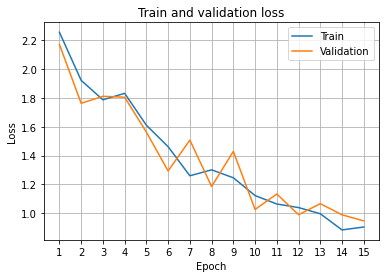

In [ ]:
fig, ax = plt.subplots()
epochs = [str(i + 1) for i in range(num_epochs)]
ax.plot(epochs, train_losses, label='Train')
ax.plot(epochs, val_losses, label='Validation')
ax.grid()
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Train and validation loss')
ax.legend()
plt.show()

### Test the Model

Test Loss:0.6870: 100%|██████████| 4/4 [00:00<00:00, 127.75it/s]



142 / 219 correct (Acc.: 64.84018264840182 and loss: 0.8030)


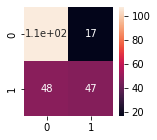

In [ ]:
confusion = np.zeros(shape=(2, 2))
num_samples = 0
num_correct = 0
loss = 0

reduced_gene_exp_model.eval()
with torch.no_grad():
     with tqdm(enumerate(test_loader), total=len(test_loader)) as pbar:
       for i, (X, y) in pbar:
            X = X.to(device=device)
            y = y.to(device=device)
            scores = reduced_gene_exp_model(X)
            batch_loss = criterion(scores, y)
            loss += batch_loss * batch_size
            _, preds = scores.max(1)
            confusion += confusion_matrix(
                y.detach().cpu().numpy(), 
                preds.detach().cpu().numpy(), 
                labels=np.arange(2))
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            pbar.set_description(f'Test Loss:{loss/((i + 1) * batch_size):.4f}')
loss /= len(test_loader.dataset)

acc = float(num_correct) / num_samples
print(f'\n{num_correct} / {num_samples} correct (Acc.: {100 * acc} and loss: {loss:.4f})')

plt.figure(figsize = (2,2))
sns.heatmap(confusion, annot=True)
plt.show()

# Model Comparison (10 Points)

Compare different models and different datasets (clinical, gene expressions, and gene reduced expressions) and try to explain their differences.

## Classical vs Neural Network Model

According to the results, classical models work better on the given datasets.
Because the data is sparse and building a complex model over it results in overfitting.
So, simpler models such as Random Forrest and XGBoost reach better results on Clinical and Reduced Gene Expression datasets and on par on Gene Expression dataset.

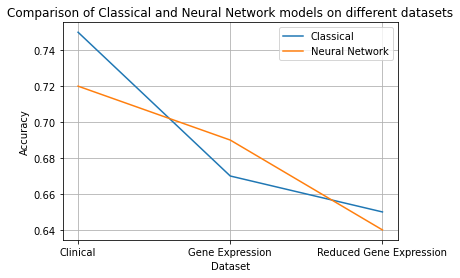

In [11]:
fig, ax = plt.subplots()
datasets = ['Clinical', 'Gene Expression', 'Reduced Gene Expression']
classical_accuracies = [0.75, 0.67, 0.65]
nn_accuracies = [0.72, 0.69, 0.64]
ax.plot(classical_accuracies, label='Classical')
ax.plot(nn_accuracies, label='Neural Network')
ax.grid()
ax.set_xlabel('Dataset')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(datasets)
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Classical and Neural Network models on different datasets')
ax.legend()
plt.show()

## Different Datasets

And comparing different datasets we get the best accuracy on the Clinical dataset which shows that it gives us better information for predicting cancer survival.
The Gene Expression dataset features have low correlation and though it is difficult to infer cancer survival from this data.
Detailed exploration has been done in the EDA section.